In [1]:
# Install dependencies
!pip install -q transformers==4.44.2 peft==0.12.0 datasets==2.21.0 optuna==4.0.0 scikit-learn==1.5.1 accelerate==0.34.2


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 102.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 90.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 97.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.1 which is incompatible.


In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Imports and setup
import os, time, random, numpy as np, pandas as pd, torch, optuna
from pathlib import Path

from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix, classification_report

from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, set_seed
)
from peft import LoraConfig, get_peft_model, TaskType


In [4]:
# ==== BERT MODEL CONFIGURATION ====
MODEL_ID = "bert-base-uncased"
# ==================================

SEED = 4213
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)
set_seed(SEED)

MAX_LEN    = 256
TRAIN_BS   = 16
EVAL_BS    = 32
OUTPUT_DIR = Path(f"outputs/{MODEL_ID.replace('/', '_')}_lora_optuna")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)


In [5]:
# Load and prepare data
df = pd.read_csv("combine_data_clean.csv", usecols=["text", "is_sarcastic"]).dropna()
df["is_sarcastic"] = df["is_sarcastic"].astype(int)

train_df, tmp_df = train_test_split(df, test_size=0.2, random_state=SEED, stratify=df["is_sarcastic"])
val_df,   test_df = train_test_split(tmp_df, test_size=0.5, random_state=SEED, stratify=tmp_df["is_sarcastic"])

train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
val_ds   = Dataset.from_pandas(val_df.reset_index(drop=True))
test_ds  = Dataset.from_pandas(test_df.reset_index(drop=True))

# Tokenization
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=True)

def tokenize(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=MAX_LEN)

train_tok = train_ds.map(tokenize, batched=True)
val_tok   = val_ds.map(tokenize, batched=True)
test_tok  = test_ds.map(tokenize, batched=True)

cols = ["input_ids", "attention_mask", "label"]
train_tok = train_tok.rename_column("is_sarcastic", "label").with_format("torch", columns=cols)
val_tok   = val_tok.rename_column("is_sarcastic", "label").with_format("torch", columns=cols)
test_tok  = test_tok.rename_column("is_sarcastic", "label").with_format("torch", columns=cols)

print(f"Train={len(train_tok)}  Val={len(val_tok)}  Test={len(test_tok)}")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/178118 [00:00<?, ? examples/s]

Map:   0%|          | 0/22265 [00:00<?, ? examples/s]

Map:   0%|          | 0/22265 [00:00<?, ? examples/s]

Train=178118  Val=22265  Test=22265


In [6]:
# Metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(-1)
    acc = accuracy_score(labels, preds)
    _, _, f1w, _ = precision_recall_fscore_support(labels, preds, average="weighted", zero_division=0)

    exps = np.exp(logits - logits.max(axis=1, keepdims=True))
    probs = exps / exps.sum(axis=1, keepdims=True)
    pos = probs[:, 1] if probs.shape[1] == 2 else np.zeros_like(labels, dtype=float)
    try:
        auc = roc_auc_score(labels, pos)
    except ValueError:
        auc = float("nan")
    return {"accuracy": acc, "f1_weighted": f1w, "roc_auc": auc}

In [7]:
# Training function with BERT-specific LoRA config
def train_eval_once(r, alpha, dropout, lr, num_epochs, out_dir):
    base = AutoModelForSequenceClassification.from_pretrained(MODEL_ID, num_labels=2)

    # BERT uses different attention module names
    lora_cfg = LoraConfig(
        task_type=TaskType.SEQ_CLS,
        r=r, lora_alpha=alpha, lora_dropout=dropout,
        target_modules=["query", "key", "value"],  # BERT attention modules
        bias="none"
    )
    model = get_peft_model(base, lora_cfg)

    args = TrainingArguments(
        output_dir=str(out_dir),
        per_device_train_batch_size=TRAIN_BS,
        per_device_eval_batch_size=EVAL_BS,
        learning_rate=lr,
        num_train_epochs=num_epochs,
        evaluation_strategy="epoch",
        save_strategy="no",
        logging_strategy="no",
        report_to="none",
        seed=SEED,
        fp16=torch.cuda.is_available(),
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_tok,
        eval_dataset=val_tok,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )
    trainer.train()
    val_metrics = trainer.evaluate()
    return val_metrics, trainer

In [8]:
# Hyperparameter tuning
def tune(n_trials=6):
    def objective(trial):
        r       = trial.suggest_categorical("r", [4, 8, 16])
        alpha   = trial.suggest_categorical("alpha", [16, 32, 64])
        dropout = trial.suggest_float("dropout", 0.0, 0.2, step=0.1)
        lr      = trial.suggest_float("lr", 5e-6, 2e-4, log=True)

        metrics, _ = train_eval_once(
            r=r, alpha=alpha, dropout=dropout, lr=lr,
            num_epochs=1,
            out_dir=OUTPUT_DIR / f"tune_t{trial.number}"
        )
        return metrics["eval_f1_weighted"]

    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=SEED))
    t0 = time.time()
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
    tune_time_sec = time.time() - t0

    bp = study.best_params
    best = {"r": int(bp["r"]), "alpha": int(bp["alpha"]), "dropout": float(bp["dropout"]), "lr": float(bp["lr"])}
    return best, study.best_value, tune_time_sec

# Run tuning
best_params, best_f1, tune_time_sec = tune(n_trials=6)
print("Best params:", best_params, " | tuning F1 (val): {:.4f}".format(best_f1))
print("Tuning time: {:.2f} min".format(tune_time_sec/60))


[I 2025-10-21 05:21:47,562] A new study created in memory with name: no-name-14481147-e4f7-4f08-9b25-001436059177


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Roc Auc
1,No log,0.426904,0.787784,0.787746,0.880154


[I 2025-10-21 05:55:36,394] Trial 0 finished with value: 0.787746111104769 and parameters: {'r': 16, 'alpha': 16, 'dropout': 0.2, 'lr': 5.880790798056653e-05}. Best is trial 0 with value: 0.787746111104769.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Roc Auc
1,No log,0.379357,0.816573,0.816798,0.907248


[I 2025-10-21 06:29:29,911] Trial 1 finished with value: 0.8167983301275255 and parameters: {'r': 4, 'alpha': 32, 'dropout': 0.1, 'lr': 0.00011435613382670692}. Best is trial 1 with value: 0.8167983301275255.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Roc Auc
1,No log,0.421514,0.792410,0.792344,0.883976


[I 2025-10-21 07:03:14,561] Trial 2 finished with value: 0.7923443948353545 and parameters: {'r': 8, 'alpha': 32, 'dropout': 0.1, 'lr': 4.5344698093739294e-05}. Best is trial 1 with value: 0.8167983301275255.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Roc Auc
1,No log,0.467292,0.765821,0.765208,0.854770


[I 2025-10-21 07:35:31,445] Trial 3 finished with value: 0.7652082794995654 and parameters: {'r': 4, 'alpha': 16, 'dropout': 0.0, 'lr': 3.5933204300472105e-05}. Best is trial 1 with value: 0.8167983301275255.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Roc Auc
1,No log,0.484541,0.756299,0.755453,0.843265


[I 2025-10-21 08:09:27,522] Trial 4 finished with value: 0.7554534493746957 and parameters: {'r': 4, 'alpha': 32, 'dropout': 0.2, 'lr': 2.385613450617807e-05}. Best is trial 1 with value: 0.8167983301275255.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Roc Auc
1,No log,0.385926,0.814058,0.814278,0.904427


[I 2025-10-21 08:41:55,218] Trial 5 finished with value: 0.8142779351890815 and parameters: {'r': 4, 'alpha': 32, 'dropout': 0.0, 'lr': 0.00010007286900120292}. Best is trial 1 with value: 0.8167983301275255.


Best params: {'r': 4, 'alpha': 32, 'dropout': 0.1, 'lr': 0.00011435613382670692}  | tuning F1 (val): 0.8168
Tuning time: 200.13 min


In [9]:
# Final training
t1 = time.time()
val_metrics, trainer = train_eval_once(
    **best_params,
    num_epochs=2,
    out_dir=OUTPUT_DIR / "final"
)
train_time_sec = time.time() - t1

# Test evaluation
pred_test = trainer.predict(test_tok)
test_metrics = compute_metrics((pred_test.predictions, pred_test.label_ids))

summary = pd.DataFrame([{
    "model_id": MODEL_ID,
    "best_params": best_params,
    "tuning_time_min": round(tune_time_sec/60, 2),
    "final_train_time_min": round(train_time_sec/60, 2),
    "val_accuracy": float(val_metrics["eval_accuracy"]),
    "val_f1_weighted": float(val_metrics["eval_f1_weighted"]),
    "val_roc_auc": float(val_metrics["eval_roc_auc"]),
    "test_accuracy": float(test_metrics["accuracy"]),
    "test_f1_weighted": float(test_metrics["f1_weighted"]),
    "test_roc_auc": float(test_metrics["roc_auc"]),
}])

print("\n=== RESULTS SUMMARY ===")
print(summary)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Roc Auc
1,No log,0.365801,0.821738,0.821691,0.914206
2,No log,0.354162,0.830856,0.831126,0.921178



=== RESULTS SUMMARY ===
            model_id                                        best_params  \
0  bert-base-uncased  {'r': 4, 'alpha': 32, 'dropout': 0.1, 'lr': 0....   

   tuning_time_min  final_train_time_min  val_accuracy  val_f1_weighted  \
0           200.13                 66.35      0.830856         0.831126   

   val_roc_auc  test_accuracy  test_f1_weighted  test_roc_auc  
0     0.921178       0.833281          0.833529      0.924269  



Confusion Matrix (test):
 [[ 8467  1629]
 [ 2083 10086]]

Classification Report (test):
              precision    recall  f1-score   support

           0     0.8026    0.8386    0.8202     10096
           1     0.8609    0.8288    0.8446     12169

    accuracy                         0.8333     22265
   macro avg     0.8318    0.8337    0.8324     22265
weighted avg     0.8345    0.8333    0.8335     22265



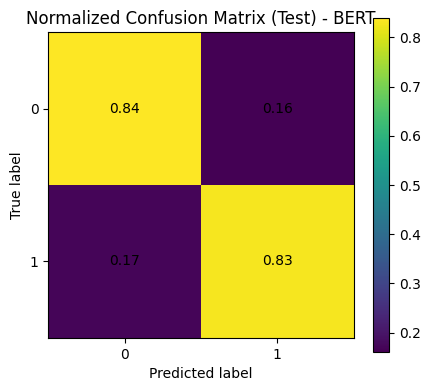

In [10]:
# Confusion matrix and classification report
import matplotlib.pyplot as plt

y_true = pred_test.label_ids
y_pred = pred_test.predictions.argmax(-1)

cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix (test):\n", cm)
print("\nClassification Report (test):")
print(classification_report(y_true, y_pred, digits=4))

cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(4.5, 4))
plt.imshow(cm_norm, interpolation='nearest')
plt.title('Normalized Confusion Matrix (Test) - BERT')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks([0,1], ['0','1'])
plt.yticks([0,1], ['0','1'])
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        plt.text(j, i, f"{cm_norm[i, j]:.2f}", ha="center", va="center")
plt.colorbar()
plt.tight_layout()
plt.show()


In [11]:
# Save adapter
adapter_dir = OUTPUT_DIR / "lora_adapter"
trainer.model.save_pretrained(str(adapter_dir))
tokenizer.save_pretrained(str(adapter_dir))

!cp -r {adapter_dir} /content/drive/MyDrive/bert_lora_adapter
print("✅ BERT LoRA adapter saved to your Google Drive root (MyDrive/bert_lora_adapter)")

✅ BERT LoRA adapter saved to your Google Drive root (MyDrive/bert_lora_adapter)
